In [1]:
#import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import time
from scipy.stats import linregress
import matplotlib.cm as cm
import matplotlib.colors as mcol
from matplotlib.pyplot import figure
import re
import datetime

test="123b89e9b48123"

api_key = "abcb89e9b48abc"

In [2]:
#Reading in csv and previewing data
movie_data_df = pd.read_csv("imdb (1000 movies) in june 2022.csv")
movie_data_df.head()

,ranking of movie\r\n,movie name\r\n,Year,certificate,runtime,genre,RATING,metascore,DETAIL ABOUT MOVIE\n,DIRECTOR\r\n,ACTOR 1\n,ACTOR 2\n,ACTOR 3,ACTOR 4,votes,GROSS COLLECTION\r\n
0,1,The Shawshank Redemption,-1994,15,142 min,Drama,9.3,81.0,Two imprisoned men bond over a number of years...,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,"2,603,314",$28.34M
1,2,The Godfather,-1972,X,175 min,"Crime, Drama",9.2,100.0,The aging patriarch of an organized crime dyna...,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,"1,798,731",$134.97M
2,3,The Dark Knight,-2008,12A,152 min,"Action, Crime, Drama",9.0,84.0,When the menace known as the Joker wreaks havo...,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,"2,574,810",$534.86M
3,4,The Lord of the Rings: The Return of the King,-2003,12A,201 min,"Action, Adventure, Drama",9.0,94.0,Gandalf and Aragorn lead the World of Men agai...,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,"1,787,701",$377.85M
4,5,Schindler's List,-1993,15,195 min,"Biography, Drama, History",9.0,94.0,"In German-occupied Poland during World War II,...",Steven Spielberg,Liam Neeson,Ralph Fiennes,Ben Kingsley,Caroline Goodall,"1,323,776",$96.90M


In [3]:
#renaming columns
clean_df = movie_data_df.rename(columns={
    "ranking of movie\r\n":"IMDB Rank",
    "movie name\r\n":"Movie Name",
    "certificate":"Rating",
    "runtime":"Runtime (Minutes)",
    "genre":"Genre",
    "RATING":"IMDB Score",
    "metascore":"Metascore",
    "DETAIL ABOUT MOVIE\n":"Details",
    "DIRECTOR\r\n":"Director",
    "ACTOR 1\n":"Actor 1",
    "ACTOR 2\n": "Actor 2",
    "ACTOR 3":"Actor 3",
    "ACTOR 4":"Actor 4",
    "votes":"IMDB Votes",
    "GROSS COLLECTION\r\n":"BoxOffice (Millions)"
})


#cleaning up columns and setting data types
#dropping null values
clean_df=clean_df.dropna()

# #cleaning year - removing "-" and setting to int

clean_df['Year'] = clean_df['Year'].str.extract(pat='(\d+)', expand=False)
clean_df["Year"]=clean_df["Year"].astype("int")

# #cleaning runtime and setting as int
clean_df["Runtime (Minutes)"]=clean_df["Runtime (Minutes)"].str.split(" ").str[0]
clean_df["Runtime (Minutes)"]=clean_df["Runtime (Minutes)"].astype("int")

# #clean up Genre to only get the first genre
clean_df["Main Genre"]=clean_df["Genre"].str.split(",").str[0]
clean_df["Sub Genre"]=clean_df["Genre"].str.split(",").str[1]
clean_df = clean_df.drop(columns="Genre")


#setting IMDB Score as int
clean_df["IMDB Score"]=clean_df["IMDB Score"].astype("float")

# #cleaning box office. Removing "$" and "M" and setting to float
clean_df["BoxOffice (Millions)"]=clean_df["BoxOffice (Millions)"].str.split("M").str[0]
clean_df["BoxOffice (Millions)"]=clean_df["BoxOffice (Millions)"].str.split("$").str[1]
clean_df["BoxOffice (Millions)"]=clean_df["BoxOffice (Millions)"].astype("float")

#Cleaning up IMDB votes and setting as int
clean_df["IMDB Votes"]=clean_df["IMDB Votes"].str.replace(",","")
clean_df["IMDB Votes"]=clean_df["IMDB Votes"].astype("int")


#standardize movie ratings
ratings = {"A":"G",
           "U":"G",
           "AA":"PG",
           "12":"PG",
           "15":"PG-13",
           "12A":"PG-13",
           "UA":"PG-13",
           "18":"R",
           "X":"NC17"}
clean_df["Rating"]=clean_df["Rating"].replace(ratings)

#resetting index and displaying
clean_df=clean_df.reset_index()
clean_df=clean_df.drop(columns="index")
clean_df.head()







,IMDB Rank,Movie Name,Year,Rating,Runtime (Minutes),IMDB Score,Metascore,Details,Director,Actor 1,Actor 2,Actor 3,Actor 4,IMDB Votes,BoxOffice (Millions),Main Genre,Sub Genre
0,1,The Shawshank Redemption,1994,PG-13,142,9.3,81.0,Two imprisoned men bond over a number of years...,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2603314,28.34,Drama,NaN
1,2,The Godfather,1972,NC17,175,9.2,100.0,The aging patriarch of an organized crime dyna...,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1798731,134.97,Crime,Drama
2,3,The Dark Knight,2008,PG-13,152,9.0,84.0,When the menace known as the Joker wreaks havo...,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2574810,534.86,Action,Crime
3,4,The Lord of the Rings: The Return of the King,2003,PG-13,201,9.0,94.0,Gandalf and Aragorn lead the World of Men agai...,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1787701,377.85,Action,Adventure
4,5,Schindler's List,1993,PG-13,195,9.0,94.0,"In German-occupied Poland during World War II,...",Steven Spielberg,Liam Neeson,Ralph Fiennes,Ben Kingsley,Caroline Goodall,1323776,96.90,Biography,Drama


In [4]:
#creating a new column to store award info
clean_df["Awards"]=""
clean_df.head()

,IMDB Rank,Movie Name,Year,Rating,Runtime (Minutes),IMDB Score,Metascore,Details,Director,Actor 1,Actor 2,Actor 3,Actor 4,IMDB Votes,BoxOffice (Millions),Main Genre,Sub Genre,Awards
0,1,The Shawshank Redemption,1994,PG-13,142,9.3,81.0,Two imprisoned men bond over a number of years...,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2603314,28.34,Drama,NaN,
1,2,The Godfather,1972,NC17,175,9.2,100.0,The aging patriarch of an organized crime dyna...,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1798731,134.97,Crime,Drama,
2,3,The Dark Knight,2008,PG-13,152,9.0,84.0,When the menace known as the Joker wreaks havo...,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2574810,534.86,Action,Crime,
3,4,The Lord of the Rings: The Return of the King,2003,PG-13,201,9.0,94.0,Gandalf and Aragorn lead the World of Men agai...,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1787701,377.85,Action,Adventure,
4,5,Schindler's List,1993,PG-13,195,9.0,94.0,"In German-occupied Poland during World War II,...",Steven Spielberg,Liam Neeson,Ralph Fiennes,Ben Kingsley,Caroline Goodall,1323776,96.90,Biography,Drama,


In [5]:
#search OMDB API for award info and put result in our new column

# for index, row in clean_df.iterrows():
#     try:
#         params = {
#         "apikey": api_key,
#         "t": row["Movie Name"]}
    
#         url = "http://www.omdbapi.com"
#         res = requests.get(url,params=params).json()
#         clean_df.loc[index,"Awards"]=res["Awards"]
#     except: 
#         pass
# clean_df.head()

In [6]:

# clean_df.to_csv("Refined_Data.csv",index=False)

In [7]:
test_df= pd.read_csv("Final_Data.csv")
test_df.head()


,IMDB Rank,Movie Name,Year,Rating,Runtime (Minutes),IMDB Score,Metascore,Details,Director,Actor 1,Actor 2,Actor 3,Actor 4,IMDB Votes,BoxOffice (Millions),Main Genre,Sub Genre,Awards,Total Awards & Nominations
0,1,The Shawshank Redemption,1994,PG-13,142,9.3,81.0,Two imprisoned men bond over a number of years...,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2603314,28.34,Drama,NaN,Nominated for 7 Oscars. 21 wins & 43 nominatio...,71
1,2,The Godfather,1972,NC17,175,9.2,100.0,The aging patriarch of an organized crime dyna...,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1798731,134.97,Crime,Drama,Won 3 Oscars. 32 wins & 31 nominations total,66
2,3,The Dark Knight,2008,PG-13,152,9.0,84.0,When the menace known as the Joker wreaks havo...,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2574810,534.86,Action,Crime,Won 2 Oscars. 162 wins & 163 nominations total,327
3,4,The Lord of the Rings: The Return of the King,2003,PG-13,201,9.0,94.0,Gandalf and Aragorn lead the World of Men agai...,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1787701,377.85,Action,Adventure,Won 11 Oscars. 213 wins & 124 nominations total,348
4,5,Schindler's List,1993,PG-13,195,9.0,94.0,"In German-occupied Poland during World War II,...",Steven Spielberg,Liam Neeson,Ralph Fiennes,Ben Kingsley,Caroline Goodall,1323776,96.90,Biography,Drama,Won 7 Oscars. 91 wins & 49 nominations total,147


In [8]:
# test_df["Total Awards & Nominations"] = 0

In [9]:

for index, row in test_df.iterrows():
    try:
        tot_awards=re.findall(r'\d+', row["Awards"])
        test_df.loc[index,"Total Awards & Nominations"]= sum(map(int, tot_awards))
    except:
        pass
        
        
        
        





In [10]:
test_df.head()

,IMDB Rank,Movie Name,Year,Rating,Runtime (Minutes),IMDB Score,Metascore,Details,Director,Actor 1,Actor 2,Actor 3,Actor 4,IMDB Votes,BoxOffice (Millions),Main Genre,Sub Genre,Awards,Total Awards & Nominations
0,1,The Shawshank Redemption,1994,PG-13,142,9.3,81.0,Two imprisoned men bond over a number of years...,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2603314,28.34,Drama,NaN,Nominated for 7 Oscars. 21 wins & 43 nominatio...,71
1,2,The Godfather,1972,NC17,175,9.2,100.0,The aging patriarch of an organized crime dyna...,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1798731,134.97,Crime,Drama,Won 3 Oscars. 32 wins & 31 nominations total,66
2,3,The Dark Knight,2008,PG-13,152,9.0,84.0,When the menace known as the Joker wreaks havo...,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2574810,534.86,Action,Crime,Won 2 Oscars. 162 wins & 163 nominations total,327
3,4,The Lord of the Rings: The Return of the King,2003,PG-13,201,9.0,94.0,Gandalf and Aragorn lead the World of Men agai...,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1787701,377.85,Action,Adventure,Won 11 Oscars. 213 wins & 124 nominations total,348
4,5,Schindler's List,1993,PG-13,195,9.0,94.0,"In German-occupied Poland during World War II,...",Steven Spielberg,Liam Neeson,Ralph Fiennes,Ben Kingsley,Caroline Goodall,1323776,96.90,Biography,Drama,Won 7 Oscars. 91 wins & 49 nominations total,147


In [11]:
# test_df.to_csv("Final_Data.csv",index=False)

# Does the amount of awards impact box office earnings?

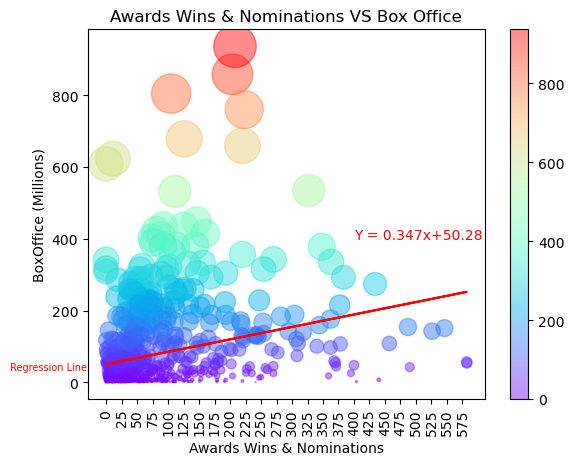

In [12]:
# Visualizations

#initializing x and y values
x=test_df["Total Awards & Nominations"]
y=test_df["BoxOffice (Millions)"]
slope, intercept, r, p, std_err = linregress(x,y)

#calculating regression line
def slopefunc(x):
    return (slope * x) + intercept
reg_line=slopefunc(x)

#plotting regression line
plt.plot(x,reg_line,color="red")

plt.scatter(x,y,alpha=.45,c=y,cmap="rainbow", s=y)
plt.title("Awards Wins & Nominations VS Box Office")
plt.ylabel("BoxOffice (Millions)")
plt.xlabel("Awards Wins & Nominations")
plt.text(400, 400, f'Y = {round(slope,3)}x+{round(intercept,3)}', fontsize = 10, color = "r")
plt.text(-155, 35, "Regression Line",fontsize = 7, color = "r")
plt.xticks((np.arange(0, max(x)+1, 25.0)))
plt.xticks(rotation='vertical')
plt.savefig("Fig_Awards Wins & Nominations VS Box Office")
plt.colorbar()
plt.show()



In [13]:
#We can see the correlation between award wins and nominations and boxoffice is 0.271396.
#This means there is NOT a strong relationship between box office amount and award wins and nominations
test_df.corr()



C:\Users\David\AppData\Local\Temp\ipykernel_5380\764660059.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  test_df.corr()


,IMDB Rank,Year,Runtime (Minutes),IMDB Score,Metascore,IMDB Votes,BoxOffice (Millions),Total Awards & Nominations
IMDB Rank,1.000000,0.098783,-0.245172,-0.937553,-0.266804,-0.512327,-0.118997,-0.183020
Year,0.098783,1.000000,0.028345,-0.174165,-0.327293,0.233082,0.252539,0.448952
Runtime (Minutes),-0.245172,0.028345,1.000000,0.265833,-0.013674,0.208728,0.159709,0.176032
IMDB Score,-0.937553,-0.174165,0.265833,1.000000,0.268320,0.622407,0.134888,0.143416
Metascore,-0.266804,-0.327293,-0.013674,0.268320,1.000000,-0.021073,-0.058636,0.235750
IMDB Votes,-0.512327,0.233082,0.208728,0.622407,-0.021073,1.000000,0.551087,0.385320
BoxOffice (Millions),-0.118997,0.252539,0.159709,0.134888,-0.058636,0.551087,1.000000,0.271396
Total Awards & Nominations,-0.183020,0.448952,0.176032,0.143416,0.235750,0.385320,0.271396,1.000000


In [14]:
#iterating through dateframe to pull movies into specific lists based on when they were made

df_1920s=[]
df_1930s=[]
df_1940s=[]
df_1950s=[]
df_1960s=[]
df_1970s=[]
df_1980s=[]
df_1990s=[]
df_2000s=[]
df_2010s=[]
df_2020s=[]

mean_BO_per_decade=[]
mean_awd_by_decade=[]


for index, row in test_df.iterrows():
    if row["Year"]<1930:
        df_1920s.append(row)
        decade_1920=pd.DataFrame(df_1920s)
        
    elif (row["Year"]>=1930) & (row["Year"]<1940):
        df_1930s.append(row)
        decade_1930=pd.DataFrame(df_1930s)
    
    elif (row["Year"]>=1940) & (row["Year"]<1950):
        df_1940s.append(row)
        decade_1940=pd.DataFrame(df_1940s)
       
    elif (row["Year"]>=1950) & (row["Year"]<1960):
        df_1950s.append(row)
        decade_1950=pd.DataFrame(df_1950s)
        
    elif (row["Year"]>=1960) & (row["Year"]<1970):
        df_1960s.append(row)
        decade_1960=pd.DataFrame(df_1960s)
        
    elif (row["Year"]>=1970) & (row["Year"]<1980):
        df_1970s.append(row)
        decade_1970=pd.DataFrame(df_1970s)
    
    elif (row["Year"]>=1980) & (row["Year"]<1990):
        df_1980s.append(row)
        decade_1980=pd.DataFrame(df_1980s)
      
       
    elif (row["Year"]>=1990) & (row["Year"]<2000): 
        df_1990s.append(row)
        decade_1990=pd.DataFrame(df_1990s)
        
    elif (row["Year"]>=2000) & (row["Year"]<2010):
        df_2000s.append(row)
        decade_2000=pd.DataFrame(df_2000s)
        
    elif (row["Year"]>=2010) & (row["Year"]<2020):
        df_2010s.append(row)
        decade_2010=pd.DataFrame(df_2010s)
    
    elif (row["Year"]>=2020) & (row["Year"]<2030):
        df_2020s.append(row)
        decade_2020=pd.DataFrame(df_2020s)


In [15]:
#calculating mean boxoffice earnings per decade and putting them into a list
mean_1920=decade_1920["BoxOffice (Millions)"].mean()
mean_1930=decade_1930["BoxOffice (Millions)"].mean()
mean_1940=decade_1940["BoxOffice (Millions)"].mean()
mean_1950=decade_1950["BoxOffice (Millions)"].mean()
mean_1960=decade_1960["BoxOffice (Millions)"].mean()
mean_1970=decade_1970["BoxOffice (Millions)"].mean()
mean_1980=decade_1980["BoxOffice (Millions)"].mean()
mean_1990=decade_1990["BoxOffice (Millions)"].mean()
mean_2000=decade_2000["BoxOffice (Millions)"].mean()
mean_2010=decade_2010["BoxOffice (Millions)"].mean()
mean_2020=decade_2020["BoxOffice (Millions)"].mean()
#creating a list of average box office earnings
mean_BO_per_decade=[mean_1920,mean_1930,mean_1940,mean_1950,mean_1960,mean_1970,mean_1980,mean_1990,mean_2000,mean_2010,mean_2020]

#calculating average awards per decade
meanawd_1920=decade_1920["Total Awards & Nominations"].mean()
meanawd_1930=decade_1930["Total Awards & Nominations"].mean()
meanawd_1940=decade_1940["Total Awards & Nominations"].mean()
meanawd_1950=decade_1950["Total Awards & Nominations"].mean()
meanawd_1960=decade_1960["Total Awards & Nominations"].mean()
meanawd_1970=decade_1970["Total Awards & Nominations"].mean()
meanawd_1980=decade_1980["Total Awards & Nominations"].mean()
meanawd_1990=decade_1990["Total Awards & Nominations"].mean()
meanawd_2000=decade_2000["Total Awards & Nominations"].mean()
meanawd_2010=decade_2010["Total Awards & Nominations"].mean()
meanawd_2020=decade_2020["Total Awards & Nominations"].mean()
#creating a list of average awards
mean_awd_by_decade=[meanawd_1920,meanawd_1930,meanawd_1940,meanawd_1950,meanawd_1960,meanawd_1970,meanawd_1980,meanawd_1990,meanawd_2000,meanawd_2010,meanawd_2020]


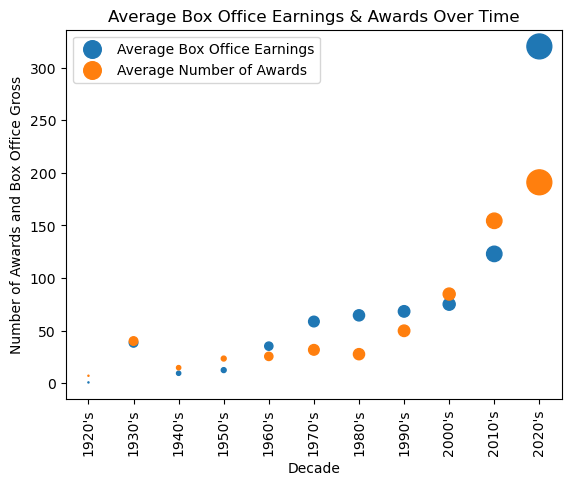

In [16]:
#plotting box office and award averages over time
decades=["1920's","1930's","1940's","1950's","1960's","1970's","1980's","1990's","2000's","2010's","2020's"]

plt.scatter(decades,mean_BO_per_decade,s=mean_BO_per_decade,label="Average Box Office Earnings")
plt.scatter(decades,mean_awd_by_decade,s=mean_BO_per_decade,label="Average Number of Awards")
plt.xticks(rotation='vertical')  
plt.ylabel("Number of Awards and Box Office Gross")
plt.xlabel("Decade")
plt.title("Average Box Office Earnings & Awards Over Time")
plt.savefig("Fig_Average Box Office Earnings & Awards Over Time")
plt.legend(loc="upper left")

In [17]:
#Analysis: In the 1960’s you were most likely to have higher box office earnings the more awards you had (based off correlation of box office and total awards nad noms.

Text(0.5, 0.98, 'Box Office Vs Amount of Awards')

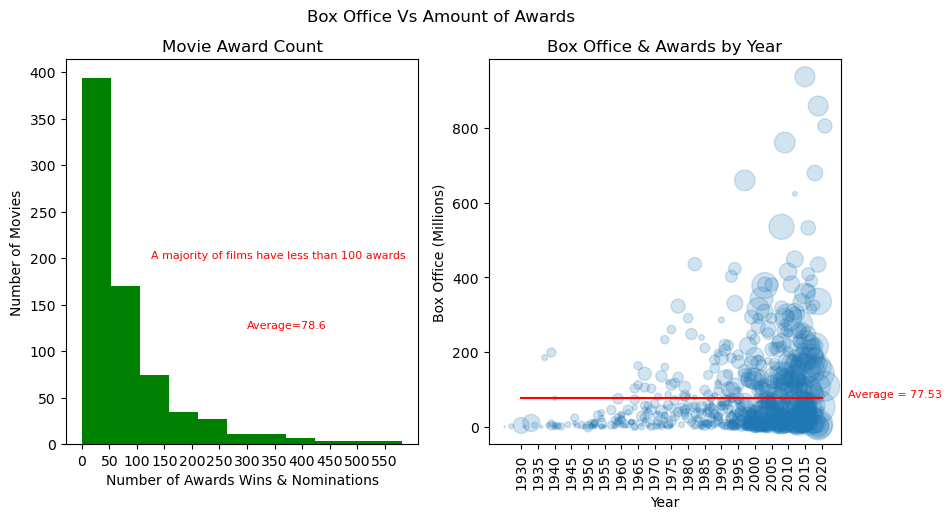

In [32]:
#creating a histogram
mean_bo=test_df["BoxOffice (Millions)"].mean()
mean_b0x=np.array([1930,1935,1940,1945,1950,1955,1960,1965,1970,1975,1980,1985,1990,1995,2000,2005,2010,2015,2020])
mean_b0xy= np.array([77.53,77.53,77.53,77.53,77.53,77.53,77.53,77.53,77.53,77.53,77.53,77.53,77.53,77.53,77.53,77.53,77.53,77.53,77.53])

fig, ax = plt.subplots(1, 2, figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(x, bins=11, color="green")
plt.title("Movie Award Count")
plt.ylabel("Number of Movies")
plt.xlabel("Number of Awards Wins & Nominations")
plt.xticks((np.arange(0, max(x)+1, 50.0)))
plt.text(125, 200, "A majority of films have less than 100 awards",fontsize = 8, color = "r")
plt.text(300, 125, "Average=78.6",fontsize = 8, color = "r")

decades=test_df.groupby(["Year"]).count()

plt.subplot(1,2,2)
x1=test_df["Year"]
y1=test_df["BoxOffice (Millions)"]
size=test_df["Total Awards & Nominations"]
plt.xticks((np.arange(1930, max(x1)+1, 5.0)))
plt.title("Box Office & Awards by Year")
plt.ylabel("Box Office (Millions)")
plt.xlabel("Year")
plt.xticks(rotation='vertical')  
plt.scatter(x1,y1,s=size,alpha=.2)
plt.plot(mean_b0x,mean_b0xy, color="red")
plt.text(2028, 80, "Average = 77.53",fontsize = 8, color = "r")
plt.savefig("Fig_3")
plt.suptitle('Box Office Vs Amount of Awards')

